In [236]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import datetime
import timeit
import os
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import *

# Data

## Get Data

In [237]:
# import data
consumer_staples = pd.read_csv("../data/S&P 500 Consumer Staples Historical Data.csv")
sp500 = pd.read_csv("../data/S&P 500 Historical Data.csv")
yield_rate = pd.read_excel("../data/yield.xlam")

## Column selection and categorization

In [238]:
consumer_staples['Date'] = consumer_staples['Date'].apply(investing_convert_time)
sp500['Date'] = sp500['Date'].apply(investing_convert_time)
sp500['Price'] = [float(str.replace(',', '')) for str in sp500['Price']]
sp500 = sp500.iloc[::-1]
yield_rate['Date'] = yield_rate['Date'].apply(yield_convert_time)
display(consumer_staples.head())
display(sp500.head())
display(yield_rate)

,Date,Price,Open,High,Low,Vol.,Change %
0,20090708,239.90,239.21,240.57,238.61,232.66M,0.27%
1,20090707,239.25,241.76,242.13,238.96,210.31M,-1.04%
2,20090706,241.76,238.16,241.77,237.17,201.16M,1.51%
3,20090702,238.16,242.23,242.23,238.16,197.82M,-1.68%
4,20090701,242.23,238.16,243.34,238.16,212.11M,1.70%


,Date,Price,Open,High,Low,Vol.,Change %
3735,20060104,1273.46,"1,268.80","1,275.37","1,267.74",-,0.37%
3734,20060105,1273.48,"1,273.46","1,276.91","1,270.30",-,0.00%
3733,20060106,1285.45,"1,273.48","1,286.09","1,273.48",-,0.94%
3732,20060109,1290.15,"1,285.45","1,290.78","1,284.82",-,0.37%
3731,20060110,1289.69,"1,290.15","1,290.15","1,283.76",-,-0.04%


,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,19900102,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1,19900103,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
2,19900104,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
3,19900105,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
4,19900108,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716,20201102,0.09,0.09,0.09,0.11,0.13,0.16,0.20,0.38,0.63,0.87,1.41,1.63
7717,20201103,0.09,0.10,0.10,0.12,0.14,0.17,0.21,0.39,0.65,0.90,1.44,1.66
7718,20201104,0.08,0.09,0.10,0.10,0.12,0.14,0.18,0.33,0.55,0.78,1.33,1.55
7719,20201105,0.09,0.10,0.10,0.10,0.12,0.14,0.18,0.33,0.56,0.79,1.32,1.54


## Split train test datasets

In [239]:
sp500_train, sp500_test = sp500[['Date', 'Price']].iloc[:-3200], sp500[['Date', 'Price']].iloc[-3200:-2900]
sp500_train.tail(), sp500_test.head(), sp500_test.tail()

(          Date    Price
 3204  20080215  1349.99
 3203  20080219  1348.78
 3202  20080220  1360.03
 3201  20080221  1342.53
 3200  20080222  1353.11,
           Date    Price
 3199  20080225  1371.80
 3198  20080226  1381.29
 3197  20080227  1380.02
 3196  20080228  1367.68
 3195  20080229  1330.63,
           Date   Price
 2904  20090427  857.51
 2903  20090428  855.16
 2902  20090429  873.64
 2901  20090430  872.81
 2900  20090501  877.52)

## select yield rate

In [240]:
yield_used = sp500_test.merge(yield_rate, how = "left")[['Date', "2 Yr", "10 Yr"]]
yield_used.head()

,Date,2 Yr,10 Yr
0,20080225,2.13,3.91
1,20080226,2.04,3.88
2,20080227,2.01,3.85
3,20080228,1.87,3.71
4,20080229,1.65,3.53


In [241]:
conversion_rate = yield_rate_convert(yield_used)
conversion_rate

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.97,
 0.97,
 1.0,
 1.0,
 0.97,
 0.93,
 0.93,
 0.97,
 1.0,
 1.0,
 1.0,
 1.0,
 0.97,
 0.93,
 0.87,
 0.87,
 0.87,
 0.93,
 0.93,
 0.93,
 0.87,
 0.87,
 0.87,
 0.93,
 0.93,
 0.93,
 0.97,
 0.97,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.87,
 0.87,
 0.87,
 0.87,
 0.87,
 0.87,
 0.97,
 0.97,
 0.93,
 0.93,
 0.87,
 0.87,
 0.93,
 0.97,
 1.0,
 1.0,
 0.97,
 0.93,
 0.93,
 0.87,
 0.93,
 0.93,
 0.97,
 0.93,
 0.93,
 0.97,
 0.97,
 0.97,
 1.0,
 1.0,
 1.0,
 0.93,
 0.93,
 0.97,
 0.93,
 0.93,
 0.93,
 0.97,
 1.0,
 1.0,
 1.0,
 0.97,
 0.97,
 0.93,
 0.97,
 0.93,
 0.97,
 0.97,
 0.97,
 0.93,
 0.93,
 0.87,
 0.87,
 0.93,
 0.97,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 

## Building Model

In [242]:
lag = 14
input_size = 2
output_size = 14
nb_epoch = 5
neurons = 10

In [243]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag, input_size):
    original = pd.DataFrame(data)
    columns = [original.shift(i) for i in range(input_size)]
    # shift to make X and y corresponds
    columns.append(original.shift(-lag))
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    # only return those rows with full data
    return df.iloc[input_size-1:-lag]

In [267]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, output_size, lag):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(output_size))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs = nb_epoch, batch_size = batch_size, verbose=0, shuffle = False)
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return np.sum(yhat[0,0])
 
price_series = sp500_train['Price']
# transform data to be stationary
train_raw_values = price_series.values
diff_values = difference(train_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag, input_size)
# select number of columns with respect to train_size
input_idx = list(range(input_size))
input_idx.append(-1)
train = supervised.iloc[:, input_idx].values

price_series = sp500_test['Price']
# transform data to be stationary
test_raw_values = price_series.values
diff_values = difference(test_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag, input_size)
test = supervised.iloc[:, input_idx].values
(train, train.shape, test, test.shape)

(array([[ 1.197e+01,  2.000e-02,  9.890e+00],
        [ 4.700e+00,  1.197e+01,  1.470e+00],
        [-4.600e-01,  4.700e+00, -5.110e+00],
        ...,
        [-6.490e+00,  8.340e+00,  1.125e+01],
        [ 2.274e+01, -6.490e+00, -1.750e+01],
        [ 1.687e+01,  2.274e+01,  1.058e+01]]),
 (520, 3),
 array([[-1.2700e+00,  9.4900e+00,  5.4140e+01],
        [-1.2340e+01, -1.2700e+00, -3.2320e+01],
        [-3.7050e+01, -1.2340e+01,  3.1090e+01],
        [ 7.1000e-01, -3.7050e+01,  2.0370e+01],
        [-4.5900e+00,  7.1000e-01,  3.1100e+00],
        [ 6.9500e+00, -4.5900e+00, -1.1860e+01],
        [-2.9360e+01,  6.9500e+00, -1.5370e+01],
        [-1.0970e+01, -2.9360e+01, -1.0540e+01],
        [-2.0000e+01, -1.0970e+01,  7.4800e+00],
        [ 4.7280e+01, -2.0000e+01,  4.7480e+01],
        [-1.1880e+01,  4.7280e+01, -2.6500e+00],
        [ 6.7100e+00, -1.1880e+01,  1.7800e+00],
        [-2.7340e+01,  6.7100e+00,  1.0900e+00],
        [-1.1540e+01, -2.7340e+01,  2.1400e+00],
        [ 5.

In [268]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, nb_epoch, neurons, output_size, lag)
# forecast the entire training dataset to build up state for forecasting
predictions = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, -input_size-1:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(history = train_raw_values, yhat = yhat, interval = len(train_scaled)-i+lag)
    # store forecast
    predictions.append(yhat)
    #expected = train_raw_values[lag + i]
print(np.array(train_raw_values).shape, np.array(predictions).shape)
rmse = np.sqrt(mean_squared_error(train_raw_values[input_size+lag:], predictions))
print('Train RMSE: %.3f' % rmse)

(536,) (520,)
Train RMSE: 38.555


In [246]:
# cross validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, -input_size-1:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, input_size, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)-i+lag)
    # store forecast
    predictions.append(yhat)
    expected = test_raw_values[input_size + i]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=1378.904506, Expected=1380.020000
Predicted=1367.059870, Expected=1367.680000
Predicted=1330.835368, Expected=1330.630000
Predicted=1331.886781, Expected=1331.340000
Predicted=1326.978541, Expected=1326.750000
Predicted=1333.691617, Expected=1333.700000
Predicted=1304.473520, Expected=1304.340000
Predicted=1293.877492, Expected=1293.370000
Predicted=1273.961470, Expected=1273.370000
Predicted=1320.710245, Expected=1320.650000
Predicted=1307.757799, Expected=1308.770000
Predicted=1314.869873, Expected=1315.480000
Predicted=1287.803671, Expected=1288.140000
Predicted=1276.825223, Expected=1276.600000
Predicted=1330.412133, Expected=1330.740000
Predicted=1297.270818, Expected=1298.420000
Predicted=1329.106353, Expected=1329.510000
Predicted=1348.454748, Expected=1349.880000
Predicted=1351.500453, Expected=1352.990000
Predicted=1340.178542, Expected=1341.130000
Predicted=1325.472846, Expected=1325.760000
Predicted=1315.320193, Expected=1315.220000
Predicted=1322.709281, Expected=

Predicted=850.417159, Expected=851.810000
Predicted=855.050973, Expected=857.390000
Predicted=885.748178, Expected=887.680000
Predicted=894.090162, Expected=896.240000
Predicted=815.492651, Expected=816.210000
Predicted=849.223176, Expected=848.810000
Predicted=869.670755, Expected=870.740000
Predicted=844.334606, Expected=845.220000
Predicted=875.644206, Expected=876.070000
Predicted=908.128643, Expected=909.700000
Predicted=887.089205, Expected=888.670000
Predicted=898.543151, Expected=899.240000
Predicted=873.147224, Expected=873.590000
Predicted=879.770717, Expected=879.730000
Predicted=868.478457, Expected=868.570000
Predicted=912.770591, Expected=913.180000
Predicted=903.091866, Expected=904.420000
Predicted=884.764161, Expected=885.280000
Predicted=887.749973, Expected=887.880000
Predicted=871.576965, Expected=871.630000
Predicted=863.389035, Expected=863.160000
Predicted=868.225798, Expected=868.150000
Predicted=872.541619, Expected=872.800000
Predicted=869.073937, Expected=869

In [247]:
conversion_rate = yield_rate_convert(yield_used[input_size:-lag])
conv_predictions = np.array(predictions) * np.array(conversion_rate)
len(conv_predictions)

284

Test RMSE: 79.603


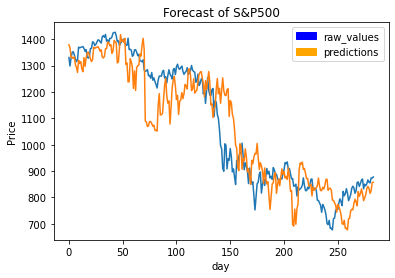

In [248]:
# report performance
rmse = np.sqrt(mean_squared_error(test_raw_values[input_size+lag:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_raw_values[input_size+lag:])
plt.plot(conv_predictions)
blue_patch = mpatches.Patch(color='blue', label='raw_values')
orange_patch = mpatches.Patch(color='orange', label='predictions')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('Price')
plt.xlabel('day')
plt.title('Forecast of S&P500')
plt.show()

## Save to csv

In [249]:
'''
pred_df = pd.DataFrame(predictions)
pred_df.index = test_df['DATENEW'][:-1]
pred_df.columns = ['Pumpkins']
pred_df
'''

"\npred_df = pd.DataFrame(predictions)\npred_df.index = test_df['DATENEW'][:-1]\npred_df.columns = ['Pumpkins']\npred_df\n"

In [250]:
'''path = os.path.join('predictions', 'Pumpkins lstm prediction.csv')
pred_df.to_csv(path)
'''

"path = os.path.join('predictions', 'Pumpkins lstm prediction.csv')\npred_df.to_csv(path)\n"

# Find Elbow Point

In [251]:
'''
# fit an LSTM network to training data
batch_size = 1
nb_epoch = 8
result = pd.DataFrame(columns = ['time', 'rmse', 'nb_epoch', 'neurons'])
for neurons in range(1, 101):
    #training part
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    test_code = '''
#model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    '''
    time_cost = timeit.timeit(stmt = test_code, setup = 'from __main__ import ' + ', '.join(globals()), number = 1)

    #predicting part
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(model, batch_size, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = test_raw_values[i]
    rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))

    #append to result
    result = result.append(pd.DataFrame({'time': [time_cost], 'rmse': rmse, 'nb_epoch': nb_epoch, 'neurons': neurons}))
result
'''

IndentationError: unexpected indent (<ipython-input-251-b5943ea43c4a>, line 16)

In [ ]:
#plt.scatter(result['time'], result['rmse'])
#plt.title('Time vs RMSE')